## Prediction using Prophet as well as SARIMAX

In [2]:
import pandas as pd
import prophet as Prophet
import predhelp as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing modules for Prophet

In [6]:
df = pd.read_csv("../../dsfgp/data/cleaned data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])

reparing df for prophet to work with

In [9]:
kol = df.columns.to_list()
add_regs_list=[]
for i in range(230):
    add_regs_list.append("add"+str(i+1))
add_regs_list
rename_df = dict(zip(kol,add_regs_list))
rename_df['DATE'] = "ds"
rename_df['Herkunftsland - Total'] = "y"

renaming DF with new column names:

In [10]:
df.rename(columns={"DATE":"ds","Herkunftsland - Total":"y"},inplace=True)

inally dropping all the country visitors

In [11]:
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States']

In [12]:
df.drop(columns=listen,inplace=True)

Now we're going to simulate the first Prophet prediction without adding regressors

Fitting dataframe into Prophet

In [13]:
m = Prophet.Prophet(yearly_seasonality=True)
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/9cpthpg1.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/fe475gg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64265', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/9cpthpg1.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/fe475gg5.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_modelnuvste8l/prophet_model-20221205161524.csv', 'method=optimize', 'algorithm=lbfgs'

making a new DF for our prediction for the future<br>

In [14]:
future = m.make_future_dataframe(periods=6, freq = 'MS')
future.tail()

ds
118 2022-11-01
119 2022-12-01
120 2023-01-01
121 2023-02-01
122 2023-03-01

getting prophet to forecast future guest numbers into the new future-df based on the data in our original df<br>

In [15]:
forecast_m = m.predict(future)

Cross validating data and getting performance metrics

In [16]:
df_cv_m = cross_validation(model=m, horizon=pd.to_timedelta(30*12, unit="D"))

INFO:prophet:Making 12 forecasts with cutoffs between 2016-04-05 00:00:00 and 2021-09-06 00:00:00
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/c16c9b9a.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/uiaped1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93301', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/c16c9b9a.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/uiaped1f.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_modelmikazpym/prophet_model-20221205161534.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:15:34 - cmdstanpy - INFO - Chain [1] start pro

Getting performance metrics

In [17]:
df_p_m = performance_metrics(df_cv_m)
m_mean_mae = np.mean(df_p_m['mae'])
m_mean_rmse = np.mean(df_p_m['rmse'])
m_mean_smape = np.mean(df_p_m['smape'])

Plotting results

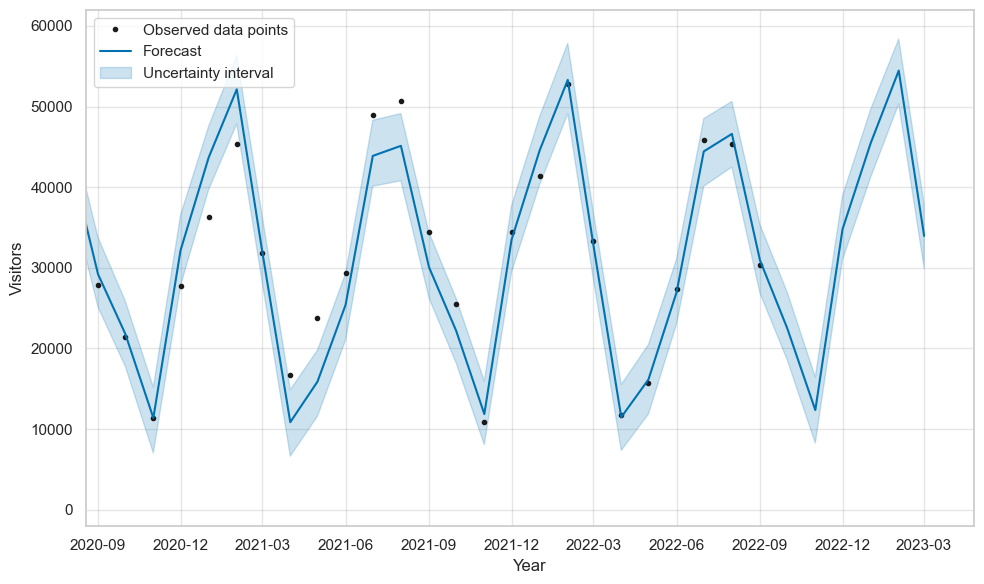

In [20]:
fig = m.plot(forecast_m, include_legend= True, xlabel = 'Year', ylabel = 'Visitors')
ax = fig.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-08-19', '2023-04-25']))
#fig.suptitle('Prophet Prediction without Regressors')
plt.show()

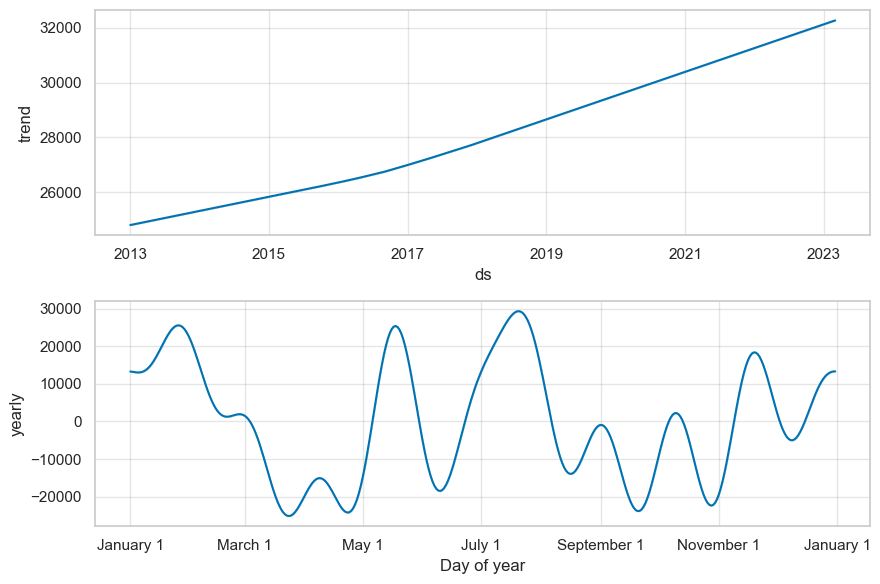

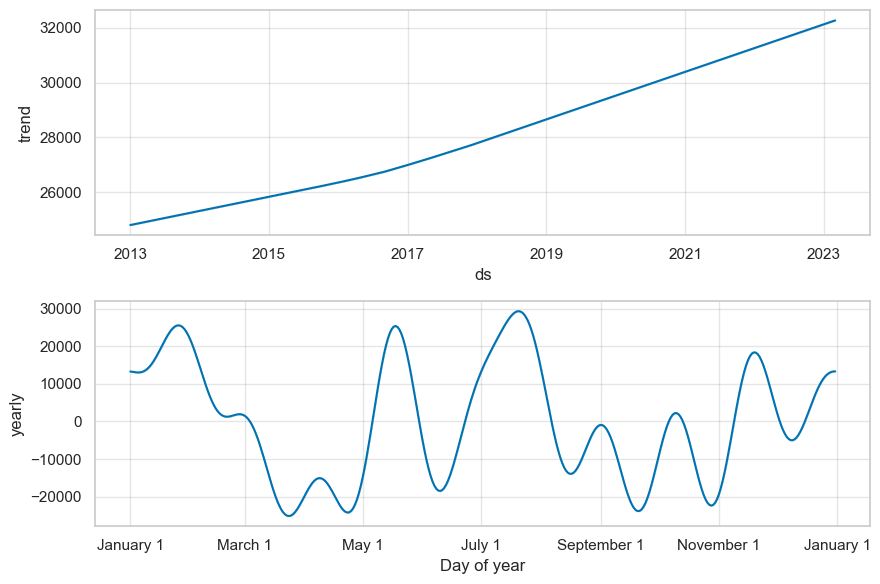

In [21]:
m.plot_components(forecast_m)

Now trying to fit some exogenous variables and be a bit more precise so lets check the correlation first:

In [21]:
df.corrwith(df["y"]).nsmallest(6)


y                           1.000000
guests-St. Moritz           0.915273
guests-Arosa                0.820817
guests-Zermatt              0.807539
cm avg. snowheight - chd    0.420122
cm avg. snowheight - gsg    0.389059
cm neuschnee - chd          0.291052
eistage - chd               0.277729
frosttage - chd             0.257593
dtype: float64

In [ ]:
df.corrwith(df["y"]).nlargest(9)

As we can see we have some very high correlations like st.moritz visitors but also low ones like rainy days with not that much downfall,<br>
thus we are going to add our top 5 correlated regressors now that are not other communes.

In [22]:
m2 = Prophet.Prophet(yearly_seasonality=True)
m2.add_regressor("cm avg. snowheight - chd", standardize=False)
m2.add_regressor('cm avg. snowheight - gsg', standardize=False)
m2.add_regressor('cm neuschnee - chd', standardize=False)
m2.add_regressor('eistage - chd', standardize=False)
m2.add_regressor('frosttage - chd', standardize=False)
m2.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/8g84gfkx.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/otp9dmrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49304', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/8g84gfkx.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/otp9dmrg.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_model95oa_6rv/prophet_model-20221205161736.csv', 'method=optimize', 'algorithm=lbfgs'

Creating future dataframes for all the different regressors

In [23]:
m_snow_chd = Prophet.Prophet(yearly_seasonality=True)
df_snow_chd = df.rename(columns = {'y' : 'bad', 'cm avg. snowheight - chd' : 'y'})
m_snow_chd.fit(df_snow_chd)
future_df_snow_chd = m_snow_chd.make_future_dataframe(periods=6, freq = 'MS')
forecast_snow_chd = m_snow_chd.predict(future_df_snow_chd)
forecast_snow_chd.rename(columns = {'yhat' : 'cm avg. snowheight - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/pzqm1lhs.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/vfc72dai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66834', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/pzqm1lhs.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/vfc72dai.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_model5mbusmry/prophet_model-20221205161740.csv', 'method=optimize', 'algorithm=lbfgs'

In [24]:
m_snow_gsg = Prophet.Prophet(yearly_seasonality=True)
df_snow_gsg = df.rename(columns = {'y' : 'bad', 'cm avg. snowheight - gsg' : 'y'})
m_snow_gsg.fit(df_snow_gsg)
future_df_snow_gsg = m_snow_gsg.make_future_dataframe(periods=6, freq = 'MS')
forecast_snow_gsg = m_snow_gsg.predict(future_df_snow_gsg)
forecast_snow_gsg.rename(columns = {'yhat' : 'cm avg. snowheight - gsg'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/mt1m9ikv.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/urxvtsjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64992', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/mt1m9ikv.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/urxvtsjr.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_model1nvacgh3/prophet_model-20221205161746.csv', 'method=optimize', 'algorithm=lbfgs'

In [25]:
m_new_snow = Prophet.Prophet(yearly_seasonality=True)
df_new_snow = df.rename(columns = {'y' : 'bad', 'cm neuschnee - chd' : 'y'})
m_new_snow.fit(df_new_snow)
future_df_new_snow = m_new_snow.make_future_dataframe(periods = 6, freq = 'MS')
forecast_new_snow = m_new_snow.predict(future_df_new_snow)
forecast_new_snow.rename(columns = {'yhat' : 'cm neuschnee - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/7r24miqg.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/043s2x7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40680', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/7r24miqg.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/043s2x7x.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_modeljiitakw2/prophet_model-20221205161752.csv', 'method=optimize', 'algorithm=lbfgs'

In [26]:
m_ice = Prophet.Prophet(yearly_seasonality=True)
df_ice = df.rename(columns = {'y' : 'bad', 'eistage - chd' : 'y'})
m_ice.fit(df_ice)
future_df_ice = m_ice.make_future_dataframe(periods=6, freq = 'MS')
forecast_ice = m_ice.predict(future_df_ice)
forecast_ice.rename(columns = {'yhat' : 'eistage - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/3k9jcmrz.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/l9xl22vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41172', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/3k9jcmrz.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/l9xl22vl.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_modelvjrfb3nk/prophet_model-20221205161758.csv', 'method=optimize', 'algorithm=lbfgs'

In [27]:
m_frost = Prophet.Prophet(yearly_seasonality=True)
df_frost = df.rename(columns = {'y' : 'bad', 'frosttage - chd' : 'y'})
m_frost.fit(df_frost)
future_df_frost = m_frost.make_future_dataframe(periods=6, freq = 'MS')
forecast_frost = m_frost.predict(future_df_frost)
forecast_frost.rename(columns = {'yhat' : 'frosttage - chd'}, inplace = True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/w4i1tv2_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/99563b_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25503', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/w4i1tv2_.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/99563b_a.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_modelv9f3mm5u/prophet_model-20221205161804.csv', 'method=optimize', 'algorithm=lbfgs'

Creating future dataframe for our main dataframe and merging it with the different regressors.

In [28]:
future_df = m2.make_future_dataframe(periods=6, freq = 'MS')

In [29]:
future_df = pd.merge(future_df, forecast_frost[['frosttage - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_ice[['eistage - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_new_snow[['cm neuschnee - chd', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_snow_gsg[['cm avg. snowheight - gsg', 'ds']], on = 'ds', how = 'inner')
future_df = pd.merge(future_df, forecast_snow_chd[['cm avg. snowheight - chd', 'ds']], on = 'ds', how = 'inner')

Forecasting our dataframe with our different regressors.

In [30]:
forecast_m2 = m2.predict(future_df)

Cross validating

In [31]:
df_cv_m2 = cross_validation(m2, horizon = pd.to_timedelta(30*12, unit="D"))

INFO:prophet:Making 12 forecasts with cutoffs between 2016-04-05 00:00:00 and 2021-09-06 00:00:00
  0%|          | 0/12 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/90jqsp0m.json
DEBUG:cmdstanpy:input tempfile: /var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/me1pcye5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16502', 'data', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/90jqsp0m.json', 'init=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/me1pcye5.json', 'output', 'file=/var/folders/pj/5_51d77x0lbdcvsbw8bfblkc0000gn/T/tmp_0i52618/prophet_model5qo40tkw/prophet_model-20221205161817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:18:17 - cmdstanpy - INFO - Chain [1] start pro

Getting our different metrics to compare old prediction with new prediction, namely functions m and m2.

In [32]:
df_p_m2 = performance_metrics(df_cv_m2)
m2_mean_mae = np.mean(df_p_m2['mae'])
m2_mean_rmse = np.mean(df_p_m2['rmse'])
m2_mean_smape = np.mean(df_p_m2['smape'])

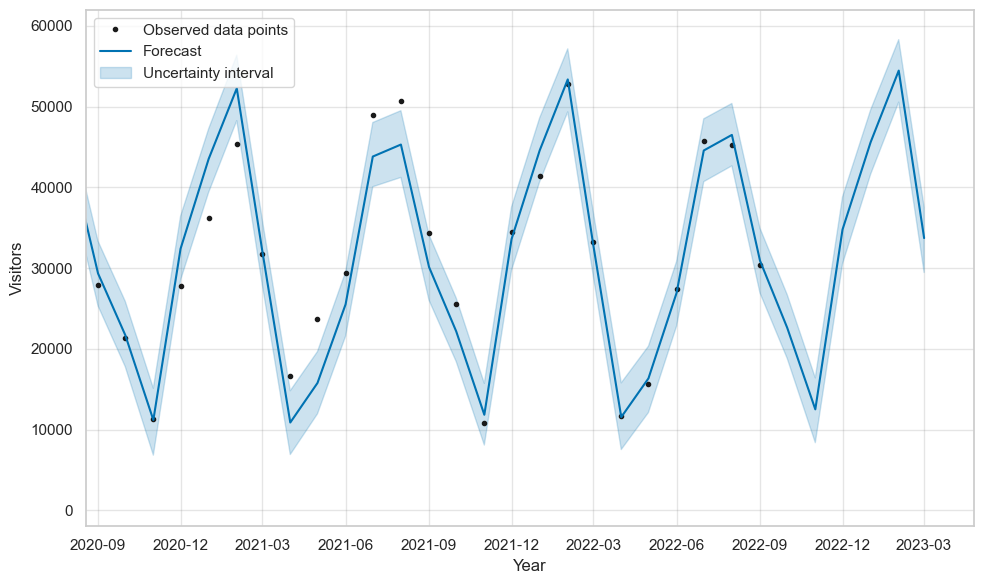

In [35]:
ax1_m2 = m2.plot(forecast_m2, include_legend= True, xlabel = 'Year', ylabel = 'Visitors')
ax = ax1_m2.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-08-19', '2023-04-25']))
plt.show()

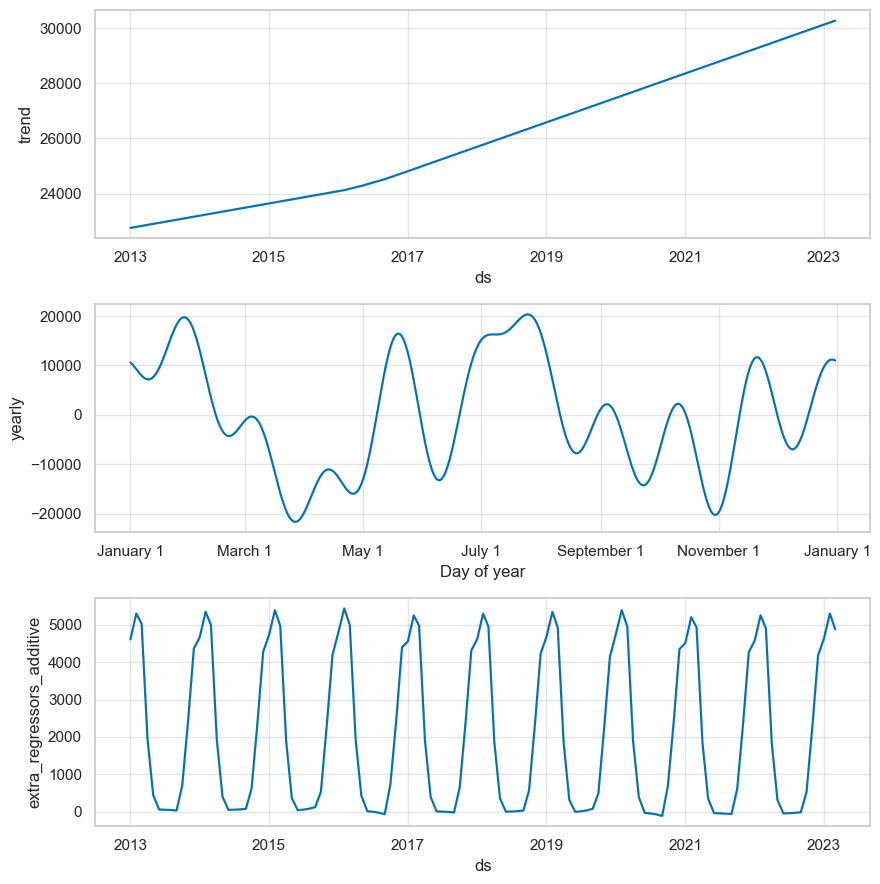

In [36]:
ax2_m2 = m2.plot_components(forecast_m2)

In [42]:
fig_pro, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12,6), dpi = 1000)
sns.lineplot(data = df_p_m2['rmse'], ax = axs[0,0]).axhline(np.mean(df_p_m2['rmse']), c='red', linestyle='dashed', label="Mean")
sns.lineplot(data = df_p_m2['mae'], ax = axs[1,0]).axhline(np.mean(df_p_m2['mae']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m2['smape'], ax = axs[2,0]).axhline(np.mean(df_p_m2['smape']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['rmse'], ax = axs[0,1]).axhline(np.mean(df_p_m['rmse']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['mae'], ax = axs[1,1]).axhline(np.mean(df_p_m['mae']), c='red', linestyle='dashed')
sns.lineplot(data = df_p_m['smape'], ax = axs[2,1]).axhline(np.mean(df_p_m['smape']), c='red', linestyle='dashed')
axs[0,0].set_title('Prediction with Regressors')
axs[0,1].set_title('Prediction without Regressors')
axs[0,0].set_ylim(2400, 7700)
axs[0,1].set_ylim(2400, 7700)
axs[1,0].set_ylim(1700, 5500)
axs[1,1].set_ylim(1700, 5500)
axs[2,0].set_ylim(0.05, 0.47)
axs[2,1].set_ylim(0.05, 0.47)
fig_pro.legend(loc = "lower center")
plt.plot()

[]

In [39]:
df_bar = pd.DataFrame(index = [0])
df_bar['m2_mean_rmse'] = m2_mean_rmse
df_bar['m_mean_rmse'] = m_mean_rmse
df_bar['m2_mean_mae'] = m2_mean_mae
df_bar['m_mean_mae'] = m_mean_mae
df_bar['m2_mean_smape'] = m2_mean_smape
df_bar['m_mean_smape'] = m_mean_smape

In [40]:
fig, ax_bar = plt.subplots(1,3,figsize = (12, 6), dpi = 1000)
palette = sns.color_palette("Paired")
sns.barplot(data = df_bar[['m2_mean_rmse','m_mean_rmse']], ax = ax_bar[0], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
sns.barplot(data = df_bar[['m2_mean_mae', 'm_mean_mae']], ax = ax_bar[1], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
sns.barplot(data = df_bar[['m2_mean_smape', 'm_mean_smape']], ax = ax_bar[2], palette = palette).set(xticklabels=['With Regressors', 'Without Regressors']) 
ax_bar[0].set_title('Mean of Root-Mean-Squared Error')
ax_bar[1].set_title('Mean of Mean Absolute Error')
ax_bar[2].set_title('Mean of Symmetric Mean Absolute Percentage Error')
fig.suptitle('Various Metrics for Prophet Predictions with and without regressors')
plt.show()

Using a second model, namely SARIMAX, to predict the visitors in the region

In [6]:
from datetime import timedelta
from datetime import datetime
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = np.random.seed(0)

In [7]:
df = pd.read_csv("../../dsfgp/data/cleaned data/total_df.csv").drop(columns=["Unnamed: 0"])
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")
df["Herkunftsland - Total"]

DATE
2013-01-01    39240.0
2013-02-01    46474.0
2013-03-01    33899.0
2013-04-01     6839.0
2013-05-01     9308.0
               ...   
2022-05-01    15668.0
2022-06-01    27365.0
2022-07-01    45794.0
2022-08-01    45299.0
2022-09-01    30397.0
Name: Herkunftsland - Total, Length: 117, dtype: float64

list with all the countries so we can drop them for our preds

In [8]:
listen = ['Argentina',
 'Australien',
 'Austria',
 'Bahrain',
 'Belarus',
 'Belgium',
 'Brasil',
 'Bulgaria',
 'Canada',
 'China',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hongkong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Kuwait',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Oman',
 'Philippinen',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Serbia',
 'Singapore',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'South Korea',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'Ukraine',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 "Herkunftsland - Total"]

In [9]:
#preparing our df and defining exogenous variables as well as our endogenous variable
#creating array with n observations of variables and k number of variables and then filling it
exog = df.drop(columns=listen).to_numpy()
exo = df.drop(columns=listen)
endo = df["Herkunftsland - Total"]

plotting endo to check if it's static, which it seems...

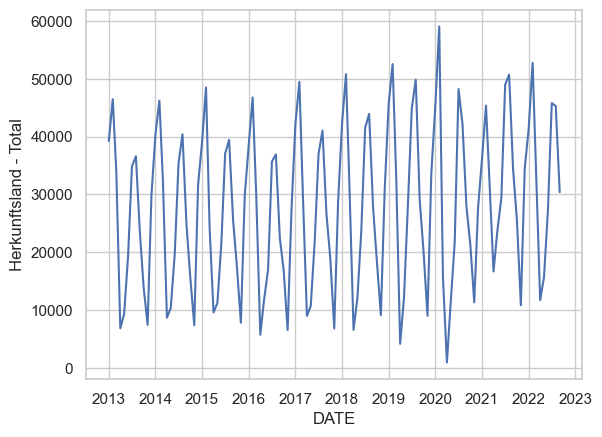

In [10]:
sns.lineplot(endo)
plt.show()

but to be really sure we can check it's stationarity with an augmented dickey-fuller-test

In [11]:
ph.check_stationarity(endo)

The series is NOT stationary according to Dickey-Fuller
The series is NOT stationary according to Kwiatkowski-Phillips-Schmidt-Shin


# Freude herrscht! Apparently it's not - as if it wasn't hard enough already<br>
*at least we now know that d is not equal to 0 - but i'll get to that later*

let's try to make endo stationary by removing the trend:<br>
we try to do this by taking the difference of between the current value and the prior month's value

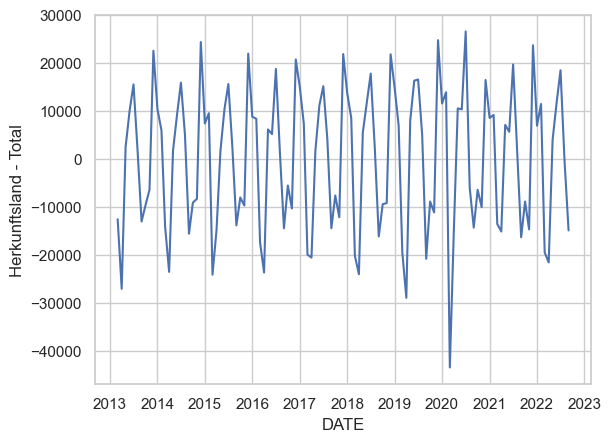

The series is stationary according to Dickey-Fuller
The series is NOT stationary according to Kwiatkowski-Phillips-Schmidt-Shin


In [12]:
endo_diff = endo.diff()[2:] 
exog_diff = np.diff(exog)[2:] 
# let's check
sns.lineplot(endo_diff)
plt.show()

In [13]:
ph.check_stationarity(endo_diff)

The series is stationary according to Dickey-Fuller
The series is NOT stationary according to Kwiatkowski-Phillips-Schmidt-Shin


now we are using STL decomposition for our DF<br>
ecomposing DF into Trend, Seasonality and Residue so we can fit it into our seasonal ARIMA(X)

In [1]:
df_seasonal = seasonal_decompose(endo, model='additive')

NameError: name 'seasonal_decompose' is not defined

it's important to note a strong seasonal influence - otherwise we use ARIMA(X)

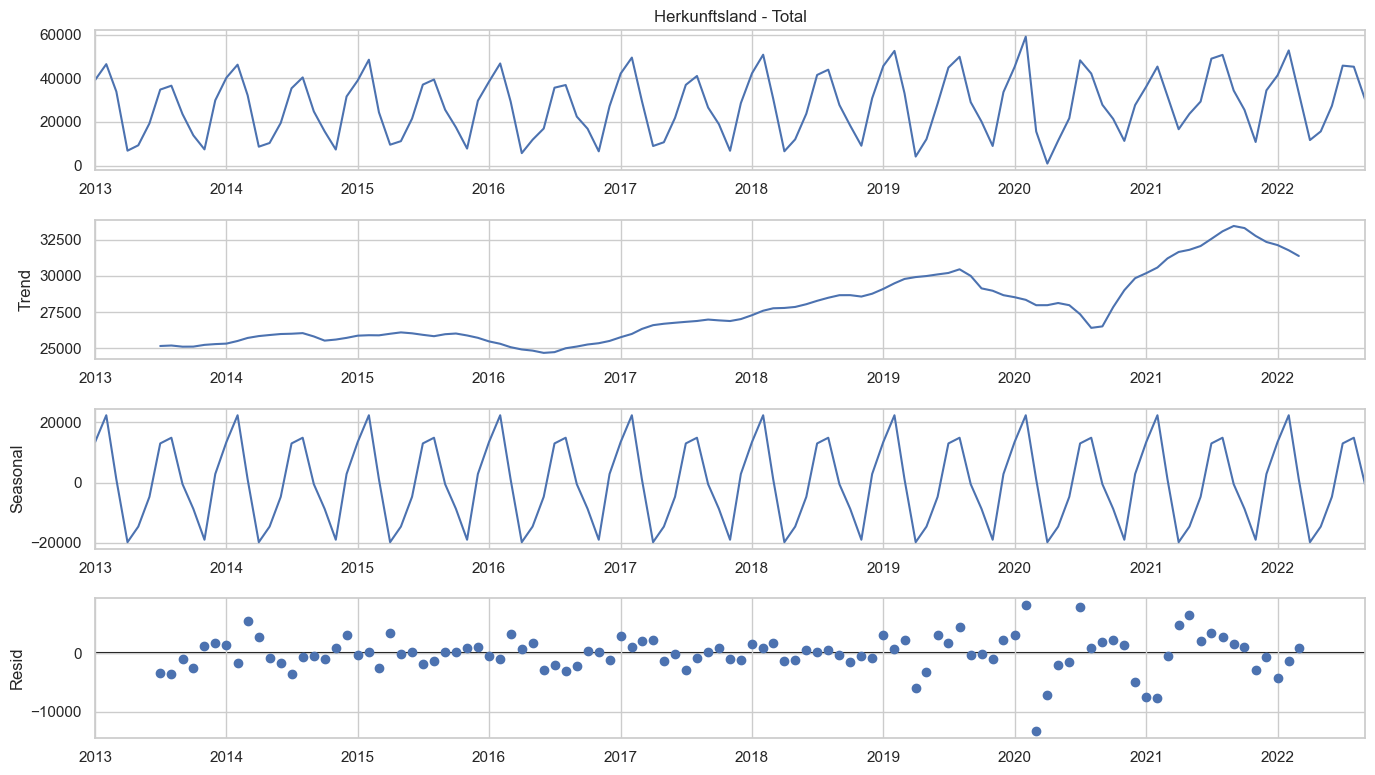

In [93]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
df_seasonal.plot();
plt.show()

### Here we can clearly see that there is some kind of trend (*and a remarkable one to say the least*) in our df<br>
#### we also notice the big seasonal differences

Trying to evaluate the ideal values of p and q using partial autocorrelation / autocorrelation functions<br>
See --> https://otexts.com/fpp2/non-seasonal-arima.html#acf-and-pacf-plots

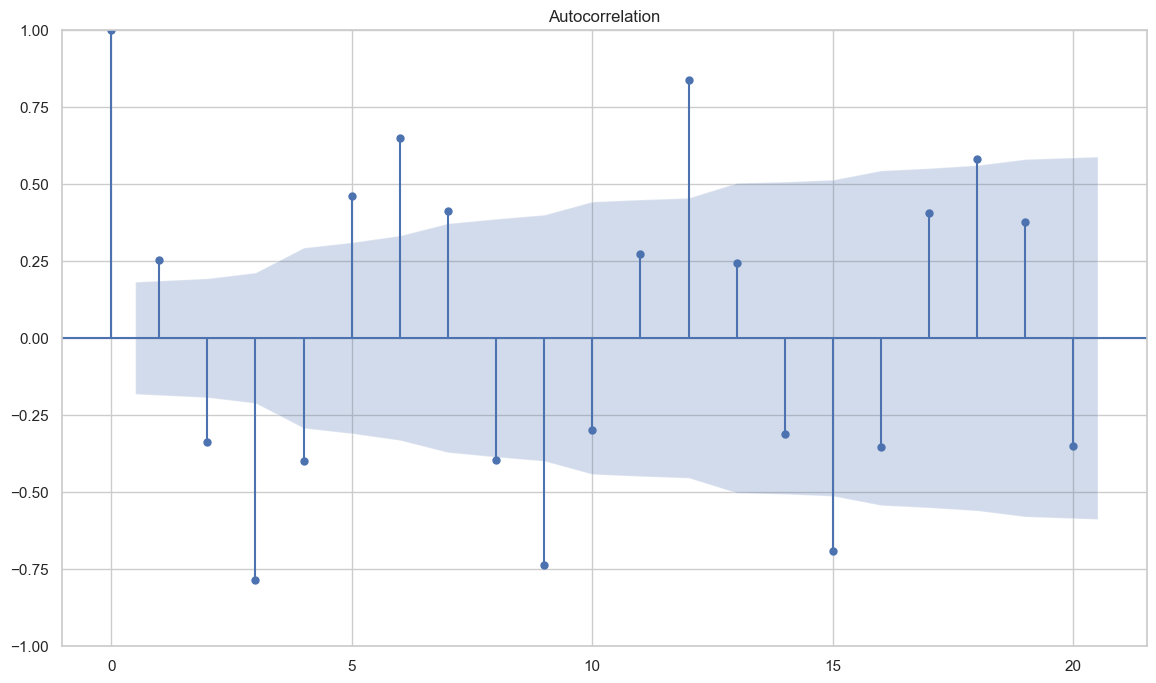

In [49]:
plot_acf(endo_diff, lags=20);9
plt.show()

## **The biggest spike is at the 12 months mark, thus implies we should continue our work with a p value of 12**

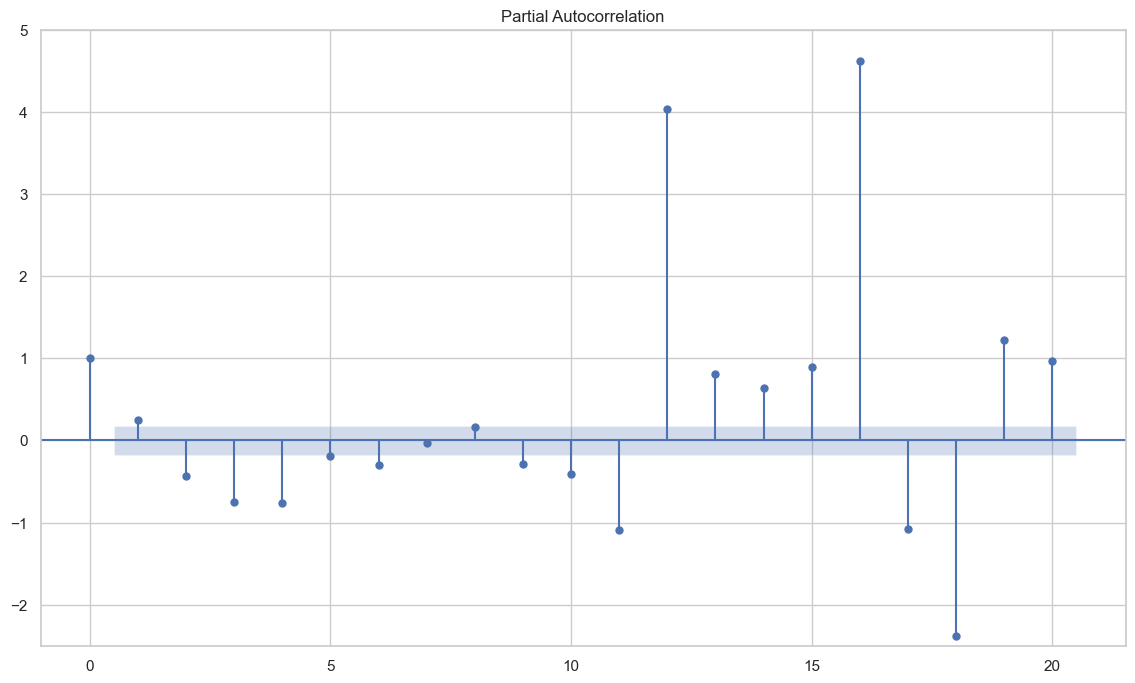

In [50]:
plot_pacf(endo_diff, lags=20)
plt.ylim(-2.5,5)
plt.show()

### There are **VERY** significant spikes at12 in our AFC and PAFC plot. - the huge spike at the 16 month could be covid -idk tho<br>

# Let's get training and testing sets now. so we can make sure our model works correctly

cross Validation by using sklearns TSSplit

In [52]:
tss = TimeSeriesSplit(n_splits=6)
#split our TS in test and train sets
for train_index, test_index in tss.split(exog):
    exog_train, exog_test = exog[train_index, :], exog[test_index,:]
    endo_train, endo_test = endo.iloc[train_index], endo.iloc[test_index]
    exo_train, exo_test = exo.iloc[train_index], exo.iloc[test_index]

showing train and test set in one plot to get an understanding of the split

<AxesSubplot:xlabel='DATE'>

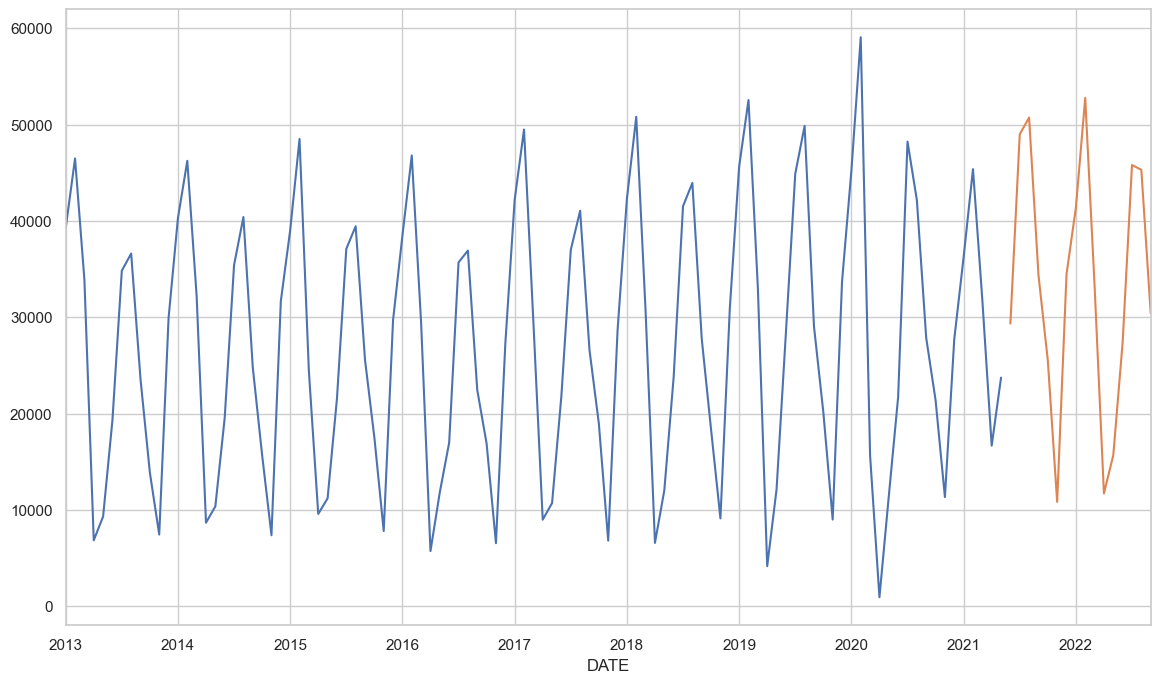

In [53]:
endo_train.groupby('DATE').mean().plot()
endo_test.groupby('DATE').mean().plot()

In [54]:
plt.show()

let's now define our training endos and exos with a d=1 and p=12 // order = pdq is 0,1,0 bc the date is very heavily influenced by seasonality however we were able to appply diff1 to it to integrate it

In [55]:
smodel = SARIMAX(endog=endo_train,exog=exo_train, order=(1,0,0), seasonal_order=(0,0,2,12))

let's fit the model now:

In [56]:
start = time()
fit_smodel = smodel.fit()
end = time()
print("The model took ", end - start,"seconds to be fitted")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          168     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05939D+01    |proj g|=  8.44052D+14

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  168      1     21      1     0     0   8.441D+14  -1.059D+01
  F =  -10.593908814534494     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


The model took  46.99792289733887 seconds to be fitted


In [57]:
forecast = fit_smodel.forecast(len(endo_test), exog=exo_test)
forecast = pd.Series(forecast, index=endo_test.index)
residue = endo_test - forecast

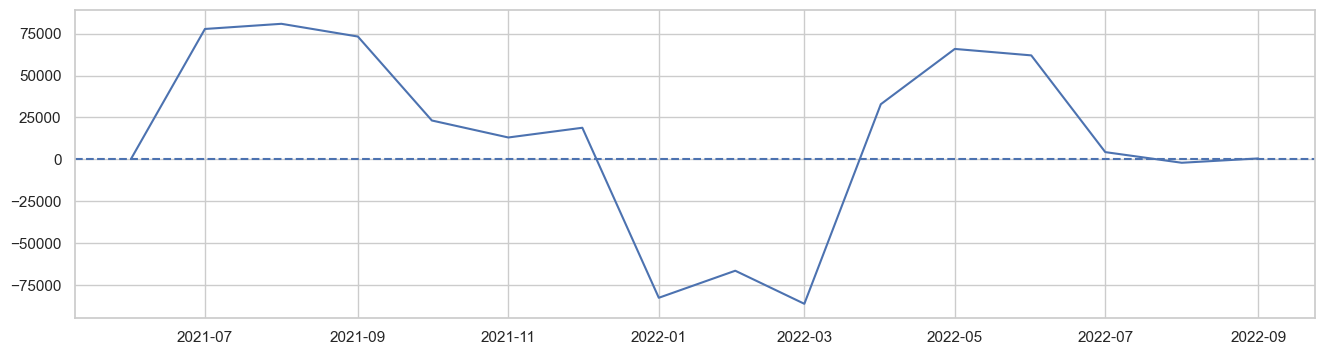

In [58]:
plt.figure(figsize=(16,4))
plt.plot(residue, label="Residual")
plt.axhline(0, linestyle="--")
plt.show()

In [59]:
print("our MAE is", np.mean(np.abs(endo_test - forecast)))

our MAE is 43127.76728284366


Now we can plot our predictions to see whether we were doing alright

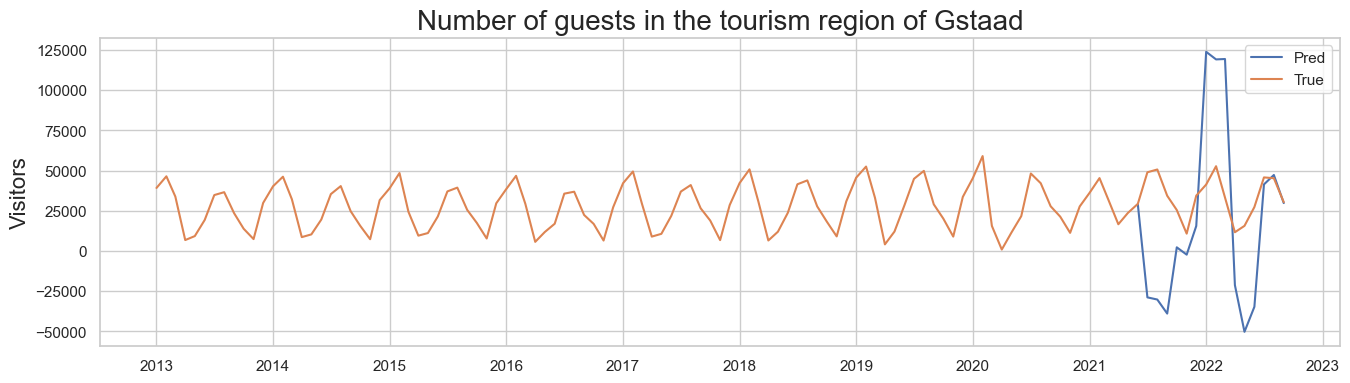

In [60]:
plt.figure(figsize=(16,4))
plt.plot(forecast, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.ylim()
plt.legend()
plt.show()

In [61]:
train_end = datetime(2021,5,1)
test_end = datetime(2022,9,1)
#startparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1,1]

In [62]:
traintrain_exo = exo[train_end:]

In [63]:
rolling_predictions = endo_test.copy()
for train_end in endo_test.index:
    train_data = endo[:train_end-timedelta(days=1)]
    train_exo = exo[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=(1,2,0), seasonal_order=(0,2,1,12),exog=train_exo)
    model_fit = model.fit(start_params=None)
    
    pred = model_fit.forecast(exog=traintrain_exo.loc[[train_end-timedelta()]])
    rolling_predictions[train_end] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  6.48211D+04


 This problem is unconstrained.


  ys=-5.754E-16  -gs= 1.618E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     95      2     1     0   7.581D+07  -2.582D+00
  F =  -2.5821077339734222     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  9.41408D+04


 This problem is unconstrained.


  ys=-2.315E-14  -gs= 3.779E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      4     84      2     1     0   3.158D+07  -2.480D+00
  F =  -2.4804330084956621     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  7.18214D+03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     62      2     0     0   8.883D+05  -9.554D-01
  F = -0.95540542590926225     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.46822D+04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     42      1     0     0   7.933D+06  -1.789D+00
  F =  -1.7886942447874481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95117D-02    |proj g|=  7.72024D+11


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   7.720D+11  -4.951D-02
  F =  -4.9511688822924768E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.37636D+04


 This problem is unconstrained.


  ys=-3.174E-13  -gs= 1.211E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     92      2     1     0   8.546D+06  -1.800D+00
  F =  -1.8003001632434619     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.42863D+04


 This problem is unconstrained.


  ys=-9.189E-13  -gs= 3.571E-06 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -1.78113D+00    |proj g|=  4.72433D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      5     70      1     1     0   4.724D+06  -1.781D+00
  F =  -1.7811295231980810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  9.46735D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     62      2     0     0   7.891D+06  -1.810D+00
  F =  -1.8097575139797064     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81068D-02    |proj g|=  1.46547D+11


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   1.465D+11  -4.811D-02
  F =  -4.8106763469583758E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  5.16091D+04


 This problem is unconstrained.


  ys=-1.775E-11  -gs= 2.818E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      3     63      2     1     0   6.843D+07  -2.661D+00
  F =  -2.6611127798582226     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.34202D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     24      1     0     0   4.763D+06  -1.794D+00
  F =  -1.7939508937144406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  7.51990D+05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     47      2     0     0   3.252D+08  -3.470D+00
  F =  -3.4702154913955057     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  5.02705D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      2     44      2     0     0   9.797D+05  -9.873D-01
  F = -0.98725281848807256     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  3.28421D+04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      4     54      1     0     0   5.893D+06  -1.827D+00
  F =  -1.8265772631188091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          167     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.18525D-01    |proj g|=  2.66549D+11


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  167      1     21      1     0     0   2.665D+11  -2.185D-01
  F = -0.21852493842438886     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [64]:
rolling_residuals = endo_test - rolling_predictions

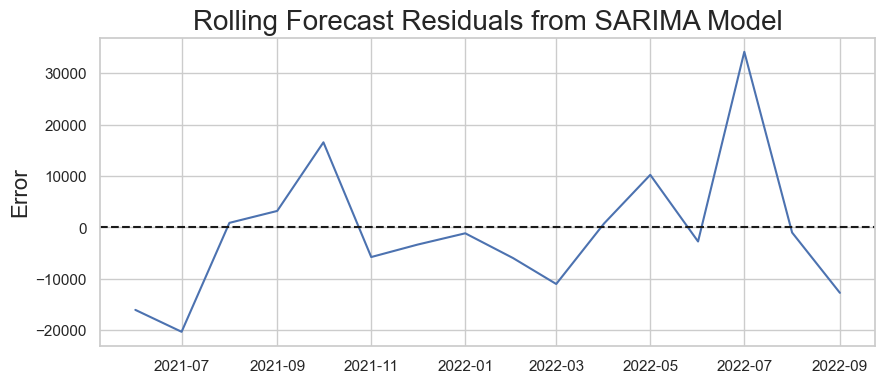

In [65]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

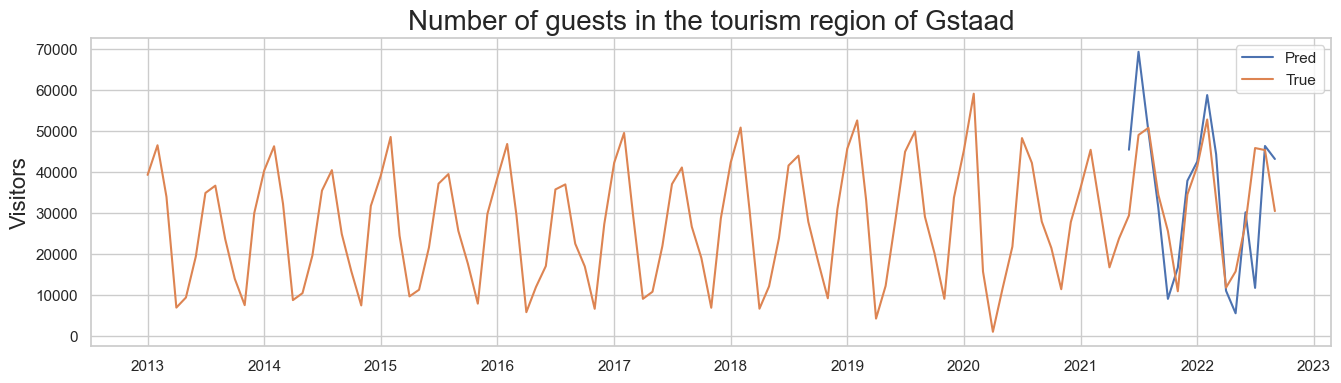

In [66]:
plt.figure(figsize=(16,4))
plt.plot(rolling_predictions, label="Pred")
plt.plot(endo, label="True")
#plt.plot(predictions4, label="Predicted3")
plt.title("Number of guests in the tourism region of Gstaad", fontsize=20)
plt.ylabel('Visitors', fontsize=16) 
plt.xlim(pd.to_datetime(['2020-08-19', '2022-12-01']))
plt.legend()
plt.show()

In [67]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [69]:
df_bar_max = pd.DataFrame(index = [0])
df_bar_max['Mean Absolute Error'] = mean_absolute_error(endo_test, rolling_predictions)
df_bar_max['Root-Mean-Squared Deviation'] = rmse(endo_test, rolling_predictions)
df_bar_max['Symmetric Mean Absolute Percentage Error'] = smape(endo_test, rolling_predictions)
df_bar_max['m_mean_rmse'] = df_bar['m_mean_rmse']
df_bar_max['m_mean_mae']  = df_bar['m_mean_mae']
df_bar_max['m_mean_smape'] = df_bar['m_mean_smape']
df_bar_max['m2_mean_rmse'] = df_bar['m2_mean_rmse']
df_bar_max['m2_mean_mae'] = df_bar['m2_mean_mae']
df_bar_max['m2_mean_smape'] = df_bar['m2_mean_smape']

In [74]:
fig, axss = plt.subplots(1,3, figsize = (15,6), dpi = 1000, constrained_layout=True)
sns.barplot(data = df_bar_max[['Root-Mean-Squared Deviation', 'm_mean_rmse', 'm2_mean_rmse']], ax = axss[0], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Root-Mean-Squared Deviation')
sns.barplot(data = df_bar_max[['Mean Absolute Error', 'm_mean_mae', 'm2_mean_mae']], ax = axss[1], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Mean Absolute Error')
sns.barplot(data = df_bar_max[['Symmetric Mean Absolute Percentage Error','m_mean_smape', 'm2_mean_smape']], ax = axss[2], palette = palette).set(xticklabels = ['SARIMAX', 'Prophet without Reg.', 'Prophet with Reg.'],ylabel = 'Symmetric Mean Absolute Percentage Error')
fig.suptitle('Comparison of Different Metrics between SARIMAX and Prophet Predictions')
plt.show()
